# Hate Speech Detection Data Analysis

## Problem Description

Hate speech is defined as any form of verbal, written, or behavioural communication that uses derogatory or discriminatory language to insult or attack an individual or a group based on attributes such as religion, ethnicity, nationality, race, colour, ancestry, gender, or other identity factors. In this project, our objective is to design a machine learning model, utilising Python, that can accurately detect instances of hate speech. 

Hate speech detection typically falls under the umbrella of sentiment classification. To train a model capable of discerning hate speech in a given text, we will utilise a dataset commonly used for sentiment classification. Specifically, for this task, we will train our hate speech detection model using Twitter data, with the aim of identifying tweets that contain hate speech.

In this notebook, we will perform data analysis and exploration on a hate speech detection dataset, as well as the NLP algorithms. The objective is to gain insights into the dataset and prepare it for further processing and modeling.

## Importing Libraries and Loading the Dataset

Let's start by importing the required libraries and loading the hate speech detection dataset.

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import spacy
spacy.load('en_core_web_sm')
from wordcloud import WordCloud
import string
from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

import seaborn as sns
from collections import Counter
from scipy.stats import boxcox, zscore

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.wrappers.scikit_learn import KerasClassifier, BaseWrapper

import xgboost as xgb
from xgboost import XGBClassifier



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zohra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Zohra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [161]:
# Load the train dataset
train_data = pd.read_csv(r'C:\Development\Github\Zozo\NLP_Hate_Speech\Week 9\datasets\train_tweets.csv')
# Load the test dataset
test_data = pd.read_csv(r'C:\Development\Github\Zozo\NLP_Hate_Speech\Week 9\datasets\tests_tweets.csv')

In [162]:
# Display the first few rows of the train dataset
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [163]:
# Display the first few rows of the test dataset
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## Basic Statistics of the Dataset

Next, we will compute some basic statistics of the dataset to gain insights into its distribution and summary statistics.

In [164]:
# Get basic statistics of the train dataset
train_data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


## Class Distribution

It's important to understand the distribution of classes in the dataset, as it will provide an overview of the prevalence of hate speech and non-hate speech tweets.

In [165]:
# Count the number of hate speech and non-hate speech tweets in the train dataset
class_counts = train_data['label'].value_counts()
class_counts

label
0    29720
1     2242
Name: count, dtype: int64

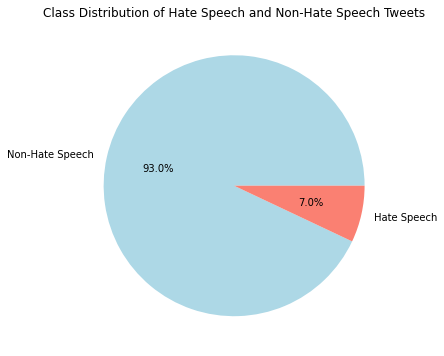

In [166]:
# Plot the class distribution using a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Non-Hate Speech', 'Hate Speech'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Class Distribution of Hate Speech and Non-Hate Speech Tweets')
plt.show()

## Data Preprocessing

### Text Preprocessing

Text preprocessing is a crucial step in natural language processing tasks. Here, we will perform various preprocessing steps to clean the tweet text and make it suitable for analysis.

In [167]:
# Perform data preprocessing steps
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove user mentions (@user)
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Handle contractions
    contractions_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "could've": "could have",
        "couldn't": "could not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'll": "he will",
        "he's": "he is",
        "how'd": "how did",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'll": "i will",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'll": "it will",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "must've": "must have",
        "mustn't": "must not",
        "needn't": "need not",
        "oughtn't": "ought not",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "she'd": "she would",
        "she'll": "she will",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "that'd": "that would",
        "that's": "that is",
        "there'd": "there would",
        "there's": "there is",
        "they'd": "they would",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'll": "we will",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "where'd": "where did",
        "where's": "where is",
        "who'll": "who will",
        "who's": "who is",
        "won't": "will not",
        "wouldn't": "would not",
        "you'd": "you would",
        "you'll": "you will",
        "you're": "you are",
        "you've": "you have"
    }
    words = text.split()
    text = ' '.join(contractions_dict[word] if word in contractions_dict else word for word in words)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [170]:
# Apply preprocessing to the train dataset
train_data['clean_text'] = train_data['tweet'].apply(preprocess_text)

In [171]:
# Apply preprocessing to the test dataset
test_data['clean_text'] = test_data['tweet'].apply(preprocess_text)

## Data Analysis and Visualization

### Analyzing the Distribution of Tweet Lengths

Analyzing the distribution of tweet lengths can provide insights into the length patterns in hate speech and non-hate speech tweets.

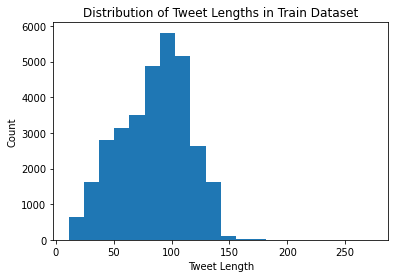

In [172]:
train_data['tweet_length'] = train_data['tweet'].apply(len)

plt.hist(train_data['tweet_length'], bins=20)
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.title('Distribution of Tweet Lengths in Train Dataset')
plt.show()

### Analysing the Distribution of Word Frequencies

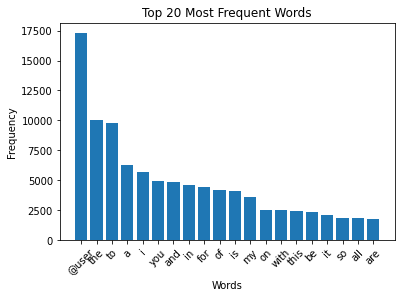

In [173]:
word_freq = train_data['tweet'].str.split(expand=True).stack().value_counts()
top_words = word_freq.head(20)
plt.bar(top_words.index, top_words.values)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.show()

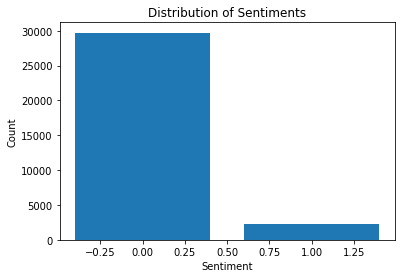

In [174]:
# Sentiment analysis
sentiment_counts = train_data['label'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

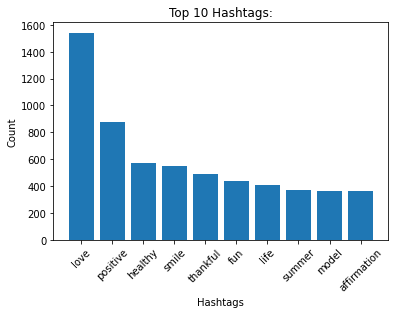

In [175]:
# Hashtag analysis
train_data['hashtags'] = train_data['tweet'].str.findall(r'#(\w+)')
hashtags = train_data['hashtags'].explode().value_counts().head(10)
plt.bar(hashtags.index, hashtags.values)
plt.xticks(rotation=45)
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.title('Top 10 Hashtags:')
plt.show()

## Feature Engineering

### TF-IDF Vectorization

For feature engineering, we will use TF-IDF vectorization to convert the preprocessed text into numerical features.

In [176]:
# Perform feature engineering using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['clean_text'])
X_test = vectorizer.transform(test_data['clean_text'])

In [177]:
# Print the shape of the train and test feature matrices
print("Train Feature Matrix Shape:", X_train.shape)
print("Test Feature Matrix Shape:", X_test.shape)

Train Feature Matrix Shape: (31962, 39550)
Test Feature Matrix Shape: (17197, 39550)


### Bag-Of-Words (BoW) 

In [178]:
# Bag-of-Words (BoW) representation
bow_vectorizer = CountVectorizer()
bow_features_X_train = bow_vectorizer.fit_transform(train_data['clean_text'])
bow_features_X_test = bow_vectorizer.fit_transform(test_data['clean_text'])

### Handling Missing Values (NA values)

In [179]:
# Check for missing values in the train_data DataFrame
train_data['tweet'].isnull().sum()

0

In [180]:
# Check for missing values in the test_data DataFrame
test_data['tweet'].isnull().sum()

0

In [181]:
def word_frequency_analysis(data):
    words = ' '.join(data).split()
    word_frequencies = Counter(words)
    return word_frequencies

# Sentiment Analysis
def sentiment_analysis(data):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = data.apply(lambda x: sid.polarity_scores(x))
    sentiment_scores = pd.DataFrame(list(sentiment_scores))
    sentiment_scores['sentiment_label'] = sentiment_scores['compound'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')
    return sentiment_scores

# Topic Modeling
def topic_modeling(data, num_topics=5):
    vectorizer = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(data)
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(doc_term_matrix)
    return vectorizer.get_feature_names_out(), lda_model

# Hashtag Analysis
def hashtag_analysis(data):
    hashtags = data.explode().value_counts().sort_values(ascending=False)
    return hashtags

# Emoji Analysis
def emoji_analysis(data):
    emoji_regex = r'(:[^:\s]*(?:::[^:\s]*)*:)|((?<!\w)\\[a-zA-Z1-9_]+(?!\w))'
    emojis = data.str.findall(emoji_regex)
    emojis = [emoji for sublist in emojis for emoji in sublist]
    emoji_counts = pd.Series(emojis).value_counts().sort_values(ascending=False)
    return emoji_counts

# Named Entity Recognition (NER)
def ner_extraction(data):
    named_entities = []
    for tweet in data:
        doc = nlp(tweet)
        entities = [ent.text for ent in doc.ents]
        named_entities.extend(entities)
    named_entity_counts = pd.Series(named_entities).value_counts().sort_values(ascending=False)
    return named_entity_counts

Top 10 Words by Frequency:
@user: 17291
the: 10065
to: 9768
a: 6261
i: 5655
you: 4949
and: 4831
in: 4570
for: 4435
of: 4152


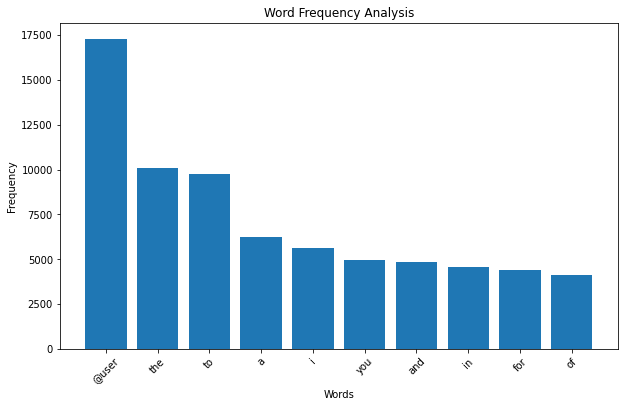

In [182]:
# Word Frequency Analysis
tweet_data = train_data['tweet'].astype(str)
word_frequencies = word_frequency_analysis(tweet_data)
top_words = word_frequencies.most_common(10)
print("Top 10 Words by Frequency:")
for word, frequency in top_words:
    print(f"{word}: {frequency}")

# Visualize word frequencies
plt.figure(figsize=(10, 6))
words = [word for word, _ in top_words]
frequencies = [frequency for _, frequency in top_words]
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Analysis')
plt.xticks(rotation=45)
plt.show()

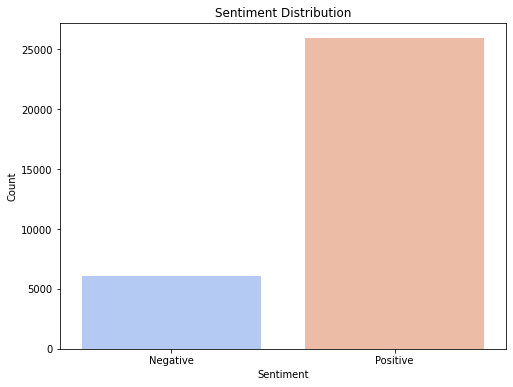

sentiment_label
Positive    25917
Negative     6045
Name: count, dtype: int64


In [183]:
# Sentiment Analysis
sentiment_scores = sentiment_analysis(tweet_data)
sentiment_distribution = sentiment_scores['sentiment_label'].value_counts()

# Sentiment Distribution Bar Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=sentiment_scores, x='sentiment_label', palette='coolwarm')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

print(sentiment_distribution)

In [184]:
# Topic Modeling
num_topics = 5
feature_names, lda_model = topic_modeling(tweet_data, num_topics)
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic #{topic_idx + 1}")
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(", ".join(top_words))

Topic #1
day, happy, new, love, father
Topic #2
love, life, time, bull, smile
Topic #3
like, amp, need, people, don
Topic #4
user, thankful, positive, amp, just
Topic #5
user, good, amp, gt, music


In [185]:
# Hashtag Analysis
hashtag_counts = hashtag_analysis(tweet_data)
print("Top 10 Hashtags:")
print(hashtag_counts.head(10))

Top 10 Hashtags:
tweet
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦                  319
i finally found a way how to delete old tweets! you might find it useful as well:    #deletetweets     82
aww yeah it's all good bing bong bing bong                                                             75
i'm so   and #grateful now that - #affirmations                                                        56
@user you might be a libtard if... #libtard  #sjw #liberal #politics                                   40
you might be a libtard if... #libtard  #sjw #liberal #politics                                         32
ð #love #instagood #photooftheday top.tags #tbt #cute #me #beautiful #followme   #followâ¦         29
have my lover stop being angry at me visit us..&gt;&gt;&gt;  #lover   #friend #astrologer #love        26
#flagday2016   #flag #day #2016 #(30 #photos) buy things about "flag day 2016": â¦                    22
get #up get   get  #enj

In [186]:
# Emoji Analysis
emoji_counts = emoji_analysis(tweet_data)
print("Top 10 Emojis:")
print(emoji_counts.head(10))

Top 10 Emojis:
(:):, )       6
(:*:, )       2
(:d:, )       2
(::, )        2
(:30-8:, )    1
(::::::, )    1
(:01:, )      1
(, \o)        1
(, \3)        1
(:42:, )      1
Name: count, dtype: int64


# Sentiment Analysis Models and Hyperparameter Tuning

In this section, we will analyze hate speech in tweets using different machine learning models and neural network-based models. We will start by preprocessing the data and then proceed to build the base models. After that, we will perform hyperparameter tuning to optimize each model's performance.

## Model 1 - Support Vector Machines (SVM)

Support Vector Machines (SVM) is a classical machine learning algorithm often used for text classification tasks. In this model, we will use the TF-IDF vectorizer to convert the tweets into numerical features and then train a linear SVM classifier.

In [187]:
# Preprocess the data
X = train_data['tweet'].values
y = train_data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [188]:
# Create the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the SVM model
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=42)

In [189]:
# Make predictions on the test data
y_pred = svm_model.predict(X_test_tfidf)

In [190]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics and classification report
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Evaluation Metrics:
Accuracy: 0.9579227279837322
Precision: 0.8816326530612245
Recall: 0.47368421052631576
F1-score: 0.6162624821683309

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5937
           1       0.88      0.47      0.62       456

    accuracy                           0.96      6393
   macro avg       0.92      0.73      0.80      6393
weighted avg       0.96      0.96      0.95      6393



## Model 2 - Recurrent Neural Network (RNN) with Word Embeddings

Recurrent Neural Networks (RNNs) are powerful models for sequential data, such as text. We will use word embeddings to represent the tweets and build an RNN model for sentiment analysis.

In [191]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data['clean_text'], train_data['label'], test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to make them of equal length
max_sequence_length = max(len(sequence) for sequence in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [192]:
# Building the RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(units=64, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [193]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [194]:
# Train the RNN model
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


720/720 [==============================] - 26s 33ms/step - loss: 0.1720 - accuracy: 0.9468 - val_loss: 0.1270 - val_accuracy: 0.9562
Epoch 2/10
720/720 [==============================] - 22s 31ms/step - loss: 0.0595 - accuracy: 0.9803 - val_loss: 0.1295 - val_accuracy: 0.9578
Epoch 3/10
720/720 [==============================] - 22s 31ms/step - loss: 0.0222 - accuracy: 0.9932 - val_loss: 0.1761 - val_accuracy: 0.9484
Epoch 4/10
720/720 [==============================] - 21s 29ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.2181 - val_accuracy: 0.9460
Epoch 5/10
720/720 [==============================] - 23s 31ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.2511 - val_accuracy: 0.9327
Epoch 6/10
720/720 [==============================] - 22s 30ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.3240 - val_accuracy: 0.9343
Epoch 7/10
720/720 [==============================] - 22s 31ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.3316 - val_accuracy: 0.9351
Epo

In [195]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

200/200 [==============================] - 1s 3ms/step


In [196]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Print the classification report
classification_report_mdl2 = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report_mdl2)

Model Evaluation Metrics:
Accuracy: 0.9562020960425466
Precision: 0.7378378378378379
Recall: 0.5986842105263158
F1-score: 0.6610169491525425
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5937
           1       0.74      0.60      0.66       456

    accuracy                           0.96      6393
   macro avg       0.85      0.79      0.82      6393
weighted avg       0.95      0.96      0.95      6393



## Model 3 - XGBoost with Bag-of-Words (BoW)

XGBoost is a popular gradient boosting algorithm known for its effectiveness in text classification tasks. In this model, we will use the Bag-of-Words (BoW) representation to convert the tweets into numerical features and then train an XGBoost classifier.

In [ ]:
# Bag-of-words (BoW) representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
# Data augmentation using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

In [ ]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_

In [ ]:
# Model Training with Best Hyperparameters
xgb_model = XGBClassifier(**best_params, random_state=42)

In [ ]:
# Train the XGB model on resampled data
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test_bow)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Print the classification report
classification_report_mdl3 = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report_mdl3)

Model Evaluation Metrics:
Accuracy: 0.9579227279837322
Precision: 0.8816326530612245
Recall: 0.47368421052631576
F1-score: 0.6162624821683309
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5937
           1       0.88      0.47      0.62       456

    accuracy                           0.96      6393
   macro avg       0.92      0.73      0.80      6393
weighted avg       0.96      0.96      0.95      6393



## Conclusion

In this notebook, we explored three different models for sentiment analysis of hate speech in tweets. We started by preprocessing the data and then built base models using SVM, RNN with word embeddings, and XGBoost with Bag-of-Words. Finally, we evaluated the performance of each model using various evaluation metrics.